<a href="https://colab.research.google.com/github/AlexeyUdod/aml/blob/master/dll_1_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание

1. Реализовать обучение линейной регрессии для задачи boston house prices (https://www.kaggle.com/vikrishnan/boston-house-prices) с использованием torch’а

** 2. Реализовать наивный баесовский классификатор для MNIST (взяв всего 2 цифры “1” и “2”) сравнить с sclearn’овским

1.  Реализовать обучение линейной регрессии для задачи boston house prices (https://www.kaggle.com/vikrishnan/boston-house-prices) с использованием torch’а

In [1]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch as tr
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import load_boston, load_digits
from random import shuffle
from functools import *
import torchvision as tv
import torch
from sklearn.naive_bayes import CategoricalNB as CNB
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

In [2]:
data = tr.tensor(load_boston()['data']).float()
target = tr.tensor(load_boston()['target']).float()

batch_size = int(data.shape[0] / 11)
dataset = TensorDataset(data, target)
data_iter = DataLoader(dataset, batch_size, shuffle=True)
n_features = dataset.tensors[0].shape[1]
X_all = dataset.tensors[0]
y_all = dataset.tensors[1]

100%|██████████| 500/500 [00:05<00:00, 87.93it/s]
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


loss = (500, tensor(197454.2969, grad_fn=<MseLossBackward>))


Text(0.5, 1.0, 'loss / iters')

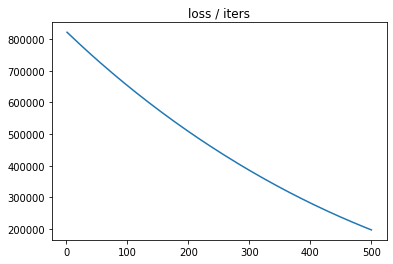

In [5]:
model = tr.nn.Linear(n_features, 1)
loss = tr.nn.MSELoss(reduction='mean')
trainer = tr.optim.Adam(model.parameters(), lr = 0.0001)
n_epochs = 500
history = []
model.weight.data = tr.ones(n_features, requires_grad = True).reshape((1,-1))
model.bias.data = tr.ones(1, requires_grad = True)

for epoch in tqdm(range(1, n_epochs + 1)):
    for X, y in data_iter:
        trainer.zero_grad()
        y_pred = model.forward(X).reshape(-1)
        l = loss(y_pred, y)
        l.backward()
        trainer.step()
    history.append((epoch, loss(model.forward(X_all).reshape(-1), y_all)))
    
print(f'loss = {epoch, loss(model.forward(X_all).reshape(-1), y_all)}')
h = tr.tensor(history)
sns.lineplot(h[:,0], h[:,1])
plt.title('loss / iters')

** 2. Реализовать наивный баесовский классификатор для MNIST (взяв всего 2 цифры “1” и “2”) сравнить с sclearn’овским

In [7]:
def data2batch(z, batch_size):
    zi = list(range(z.shape[0]))
    shuffle(zi)
    zr = z[zi]
    res = zr[slice(0, batch_size)].unsqueeze(0)
    for n in range(batch_size, z.shape[0], batch_size):   
        r = (zr[slice(n, n + batch_size)].unsqueeze(0))
        if (r.shape[1]==batch_size):
            res = tr.cat((res, r), axis=0)
    return res

def y2ohe(y):
    r = tr.zeros(10)
    r[int(y[0])] = 1
    y_ohe = r.unsqueeze(0)
    for n in y[1:]:
        r = tr.zeros(10)
        r[int(n)] = 1
        y_ohe = tr.cat((y_ohe, r.unsqueeze(0)), axis=0)
    return y_ohe

def norm(x): return (x - x.mean())/(x.max() - x.min())
def softmax(y_pred): return tr.div(tr.exp((norm(y_pred))), tr.sum(tr.exp((norm(y_pred))), axis=1).unsqueeze(1))
def MSE(y_ohe, y_prob): return tr.sum((y_ohe - y_prob)**2)
def score(y, y_prob): return tr.sum(tr.argmax(y_prob, axis=1) == y).item()/ y.shape[0]


100%|██████████| 100/100 [00:07<00:00, 13.87it/s]

model loss 78.80097198486328
model score: 0.904284919309961



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'loss / iters')

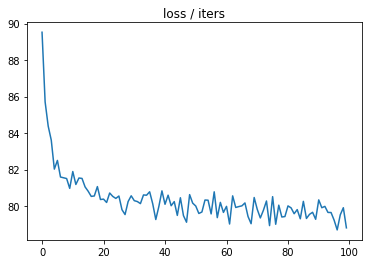

In [8]:
X = tr.tensor(load_digits()['data']).float()
Y = tr.tensor(load_digits()['target']).float()
z = tr.cat((X.float(), Y.float().unsqueeze(1)),axis=1)
res = data2batch(z, 50)
w1 = tr.rand(Y.unique().shape[0], X.shape[1], requires_grad=True)
b1 = tr.rand(1 , requires_grad=True)
lr = 0.01
l_his = []
n_iter = 100
for i in tqdm(range(n_iter)):
    for batch in (data2batch(z, 100)):
        x = batch[:,:-1]
        y = batch[:,-1]
        y_ohe = y2ohe(y)
        y_pred = tr.mm(x, w1.T) + b1 
        y_prob = softmax(y_pred)
        l = MSE(y_ohe, y_prob)
        l.backward()
        w1.detach_()
        b1.detach_()
        w1 -= (w1.grad * lr)
        b1 -= b1.grad * lr
        w1.requires_grad_(True)
        b1.requires_grad_(True)  
    l_his.append(l.item())

print(f'model loss {l}')

# model evaluate
y_pred = tr.mm(X, w1.T) + b1 
y_prob = softmax(y_pred)

print(f'model score: {score(Y, y_prob)}')
sns.lineplot(range(n_iter), l_his )
plt.title('loss / iters')

In [9]:
# native sklearn Naive Bayes
model = CNB()
model.fit(X, Y)
Y_pred = model.predict(X)
print(f'Sklearn Naive Bayes scores - {acc(Y, Y_pred)}')

Sklearn Naive Bayes scores - 0.9560378408458542
